# Step1:导入函数工具箱

In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 2:数据读取

In [3]:
## 1) 载入训练集和测试集；
Train_data = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('./data/used_car_testB_20200421.csv', sep=' ')
## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('Test data shape:',Test_data.shape)

Train data shape: (150000, 31)
Test data shape: (50000, 30)


## 2.1 数据简要浏览

In [5]:
## 2) 简略观察数据(head()+shape)
Train_data.head().append(Train_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
149995,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149996,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,...,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


所有特征集均脱敏处理
+ name - 汽车编码
+ regDate - 汽车注册时间
+ model - 车型编码
+ brand - 品牌
+ bodyType - 车身类型
+ fuelType - 燃油类型
+ gearbox - 变速箱
+ power - 汽车功率
+ kilometer - 汽车行驶公里
+ notRepairedDamage - 汽车有尚未修复的损坏
+ regionCode - 看车地区编码
+ seller - 销售方
+ offerType - 报价类型
+ creatDate - 广告发布时间
+ price - 汽车价格
+ v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' 【匿名特征，包含v0-14在内15个匿名特征】

In [4]:
Test_data.head().append(Test_data.tail())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.236050,0.101777,0.098950,0.026830,0.096614,-2.846788,2.800267,-2.524610,1.076819,0.461610
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.257000,0.000000,0.066732,0.057771,0.068852,2.839010,-1.659801,-0.924142,0.199423,0.451014
49995,249995,111443,20041005,4.0,4,0.0,NaN,1.0,150,15.0,...,0.263668,0.000292,0.141804,0.076393,0.039272,2.072901,-2.531869,1.716978,-1.063437,0.326587
49996,249996,152834,20130409,65.0,1,0.0,0.0,0.0,179,4.0,...,0.255310,0.000991,0.155868,0.108425,0.067841,1.358504,-3.290295,4.269809,0.140524,0.556221
49997,249997,132531,20041211,4.0,4,0.0,0.0,1.0,147,12.5,...,0.262933,0.000318,0.141872,0.071968,0.042966,2.165658,-2.417885,1.370612,-1.073133,0.270602
49998,249998,143405,20020702,40.0,1,4.0,0.0,1.0,176,15.0,...,0.282106,0.000023,0.067483,0.067526,0.009006,2.030114,-2.939244,0.569078,-1.718245,0.316379
49999,249999,78202,20090708,32.0,8,1.0,0.0,0.0,0,3.0,...,0.231449,0.103947,0.096027,0.062328,0.110180,-3.689090,2.032376,0.109157,2.202828,0.847469


SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1504
fuelType             2924
gearbox              1968
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

## 2.2 数据信息查看

In [5]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [6]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [7]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [8]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

## 2.3 数据统计信息浏览

In [10]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [11]:
Test_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


# Step 3:特征与标签构建
## 3.1 提取数值类型特征列名

In [15]:
Train_data.dtypes

SaleID                 int64
name                   int64
regDate                int64
model                float64
brand                  int64
bodyType             float64
fuelType             float64
gearbox              float64
power                  int64
kilometer            float64
notRepairedDamage     object
regionCode             int64
seller                 int64
offerType              int64
creatDate              int64
price                  int64
v_0                  float64
v_1                  float64
v_2                  float64
v_3                  float64
v_4                  float64
v_5                  float64
v_6                  float64
v_7                  float64
v_8                  float64
v_9                  float64
v_10                 float64
v_11                 float64
v_12                 float64
v_13                 float64
v_14                 float64
dtype: object

In [16]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [17]:
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


## 3.2  构建训练和测试样本

In [20]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = Test_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 18)
X test shape: (50000, 18)


In [21]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

## 3.3 统计标签的基本分布信息

In [22]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


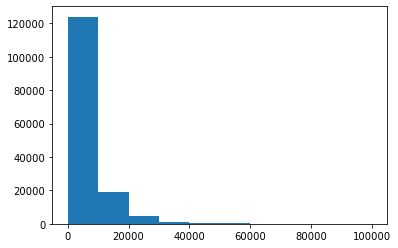

In [23]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()

## 3.4 缺省值用-1代替

In [24]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

# Step 4:模型训练与预测

## 4.1 利用xgb进行五折交叉验证查看模型的参数效果

In [25]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 622.8365678300579
Val mae 714.0856745005866


## 4.2 定义xgb和lgb模型函数

In [26]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

## 4.3 切分数据集（Train,Val）进行模型训练，评价和预测

In [27]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [28]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
MAE of val with lgb: 675.3889074468702
Predict lgb...
Sta of Predict lgb:
_min -589.8793550785414
_max: 90760.26063584947
_mean 5906.935218383807
_ptp 91350.13999092802
_std 7344.644970956768
_var 53943809.749400534


In [29]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
MAE of val with xgb: 696.0956942812867
Predict xgb...
Sta of Predict xgb:
_min -318.20892
_max: 90140.625
_mean 5910.7607
_ptp 90458.836
_std 7345.965
_var 53963196.0


## 4.4 进行两模型的结果加权融合

In [30]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 670.4524336244772


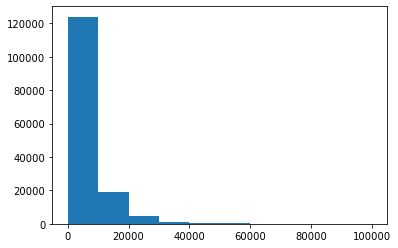

In [31]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

## 4.5 输出结果

In [32]:
sub = pd.DataFrame()
sub['SaleID'] = Test_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./result/sub_Weighted_BaseLine.csv',index=False)